In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import bmat, coo_matrix, diags, eye
from scipy.sparse.linalg import spsolve
from itertools import product

In [2]:
%matplotlib notebook

In [3]:
# Define parameters
Ds, Dc = 1, 1
kf, gam = 0, 1
lam = 0
N = 100
L = 5

z = np.linspace(0, L, num=N+1)
x = np.linspace(0, L, num=N+1)
h = x[1] - x[0]

In [4]:
# Set up matrix and vector

submatrices = [[None]*N for _ in range(N)]
rhs = [None]*N

## Construct the first block row
submatrices[0][0] = -eye(N, format='coo')
submatrices[0][1] = diags(np.ones(N-1), offsets=-1, shape=(N, N-1), format='coo')

## Construct the rest of the block matrix
for i in range(1, N):
    M = N - 1 - i
    diagonal = np.ones(N-i)
    diagonal[-1] = 0
    ### Construct the block subdiagonal
    submatrices[i][i-1] = (Ds/h**2 + kf/(2*h*gam)*(z[i] - lam))*diags(
        diagonal, offsets=1, shape=(N-i, N-i+1), format='coo')
    ### Construct the block diagonal
    part1 = diags(diagonal, offsets=0, shape=(N-i, N-i))
    if i < N - 1:
        part2 = coo_matrix(([1, -1], ([N-i-1, N-i-1], [N-i-2, N-i-1])), shape=(N-i, N-i))
    elif i == N - 1:
        part2 = coo_matrix(([-1], ([0], [0])), shape=(1,1))
    part3 = diags([diagonal[1:], diagonal[:-1]], offsets=[-1, 1], 
                  shape=(N-i, N-i), format='coo')
    submatrices[i][i] = -2*(Dc+Ds)/h**2*part1 + part2 + Dc/h**2*part3
    ### Construct the block superdiagonal
    if i < N - 1:
        submatrices[i][i+1] = (Ds/h**2 - kf/(2*h*gam)*(z[i] - lam))*diags(
            diagonal[1:], offsets=-1, shape=(N-i, N-i-1), format='coo')

## Construct a single matrix from the array of submatrices
A = bmat(submatrices, format='csr')
# print(A.toarray()) #Diagonal is correct, the superdiagonal was wrong
## Construct the rhs vector
rhs = np.zeros(N)
temp = -np.ones(N)
temp[-1] = 0
for i in range(1, N):
    rhs = np.append(rhs, temp[i:])
# print(rhs) #This is correct
## Solve the system
sol = spsolve(A, rhs)

<IPython.core.display.Javascript object>


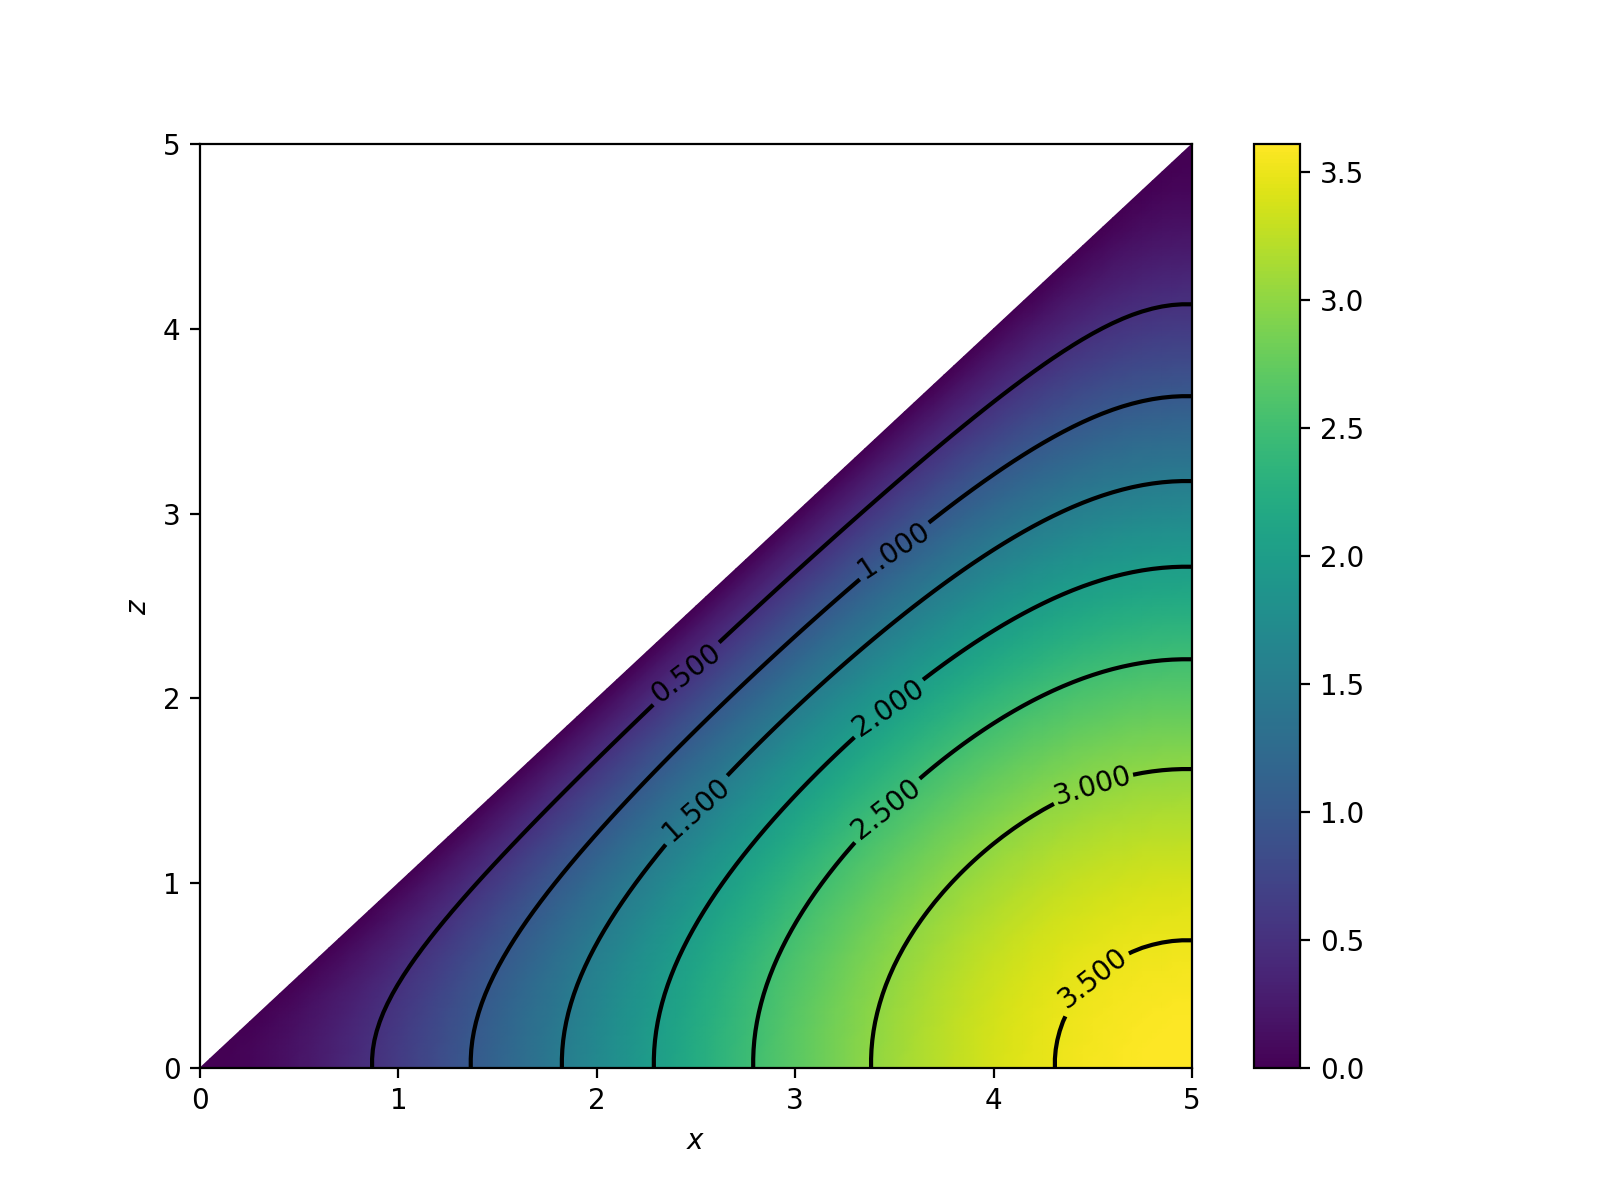

In [5]:
xtri = []
for i in range(N+1):
    xtri.append(x[i:])
xtri = np.hstack(xtri)
ztri = np.repeat(z, np.arange(1, N+2)[::-1])
npoints = xtri.shape[0]

trirows = []
for i in range(N+1, 1, -1):
    ti = i*(i+1)/2
    offset = npoints - ti
    for j in range(0, i-1):
        trirows.append(np.array([offset + j, offset + j + 1, offset + j + i]))
    if i > 2:
        for j in range(1, i-1):
            trirows.append(np.array([offset + j, offset + j + i, offset + j + i - 1]))
tri = np.vstack(trirows)

obj = []
tn = N*(N+1)/2
for i in range(N, 0, -1):
    obj.append(tn - i*(i+1)/2)
plot_sol = np.insert(sol, obj=np.array(obj), values=0)
plot_sol = np.append(plot_sol, 0)

plt.rcParams['figure.figsize'] = (8, 6)
triangulation = Triangulation(xtri, ztri, tri)
# plt.triplot(triangulation, 'k-', linewidth=0.1)
cs = plt.tricontour(triangulation, plot_sol, colors='k')
plt.clabel(cs)
plt.tripcolor(triangulation, plot_sol, shading='gouraud')
plt.xlabel('$x$')
plt.ylabel('$z$')
plt.colorbar()
plt.savefig('notebook-hm.png', dpi=300)
plt.show()

<IPython.core.display.Javascript object>


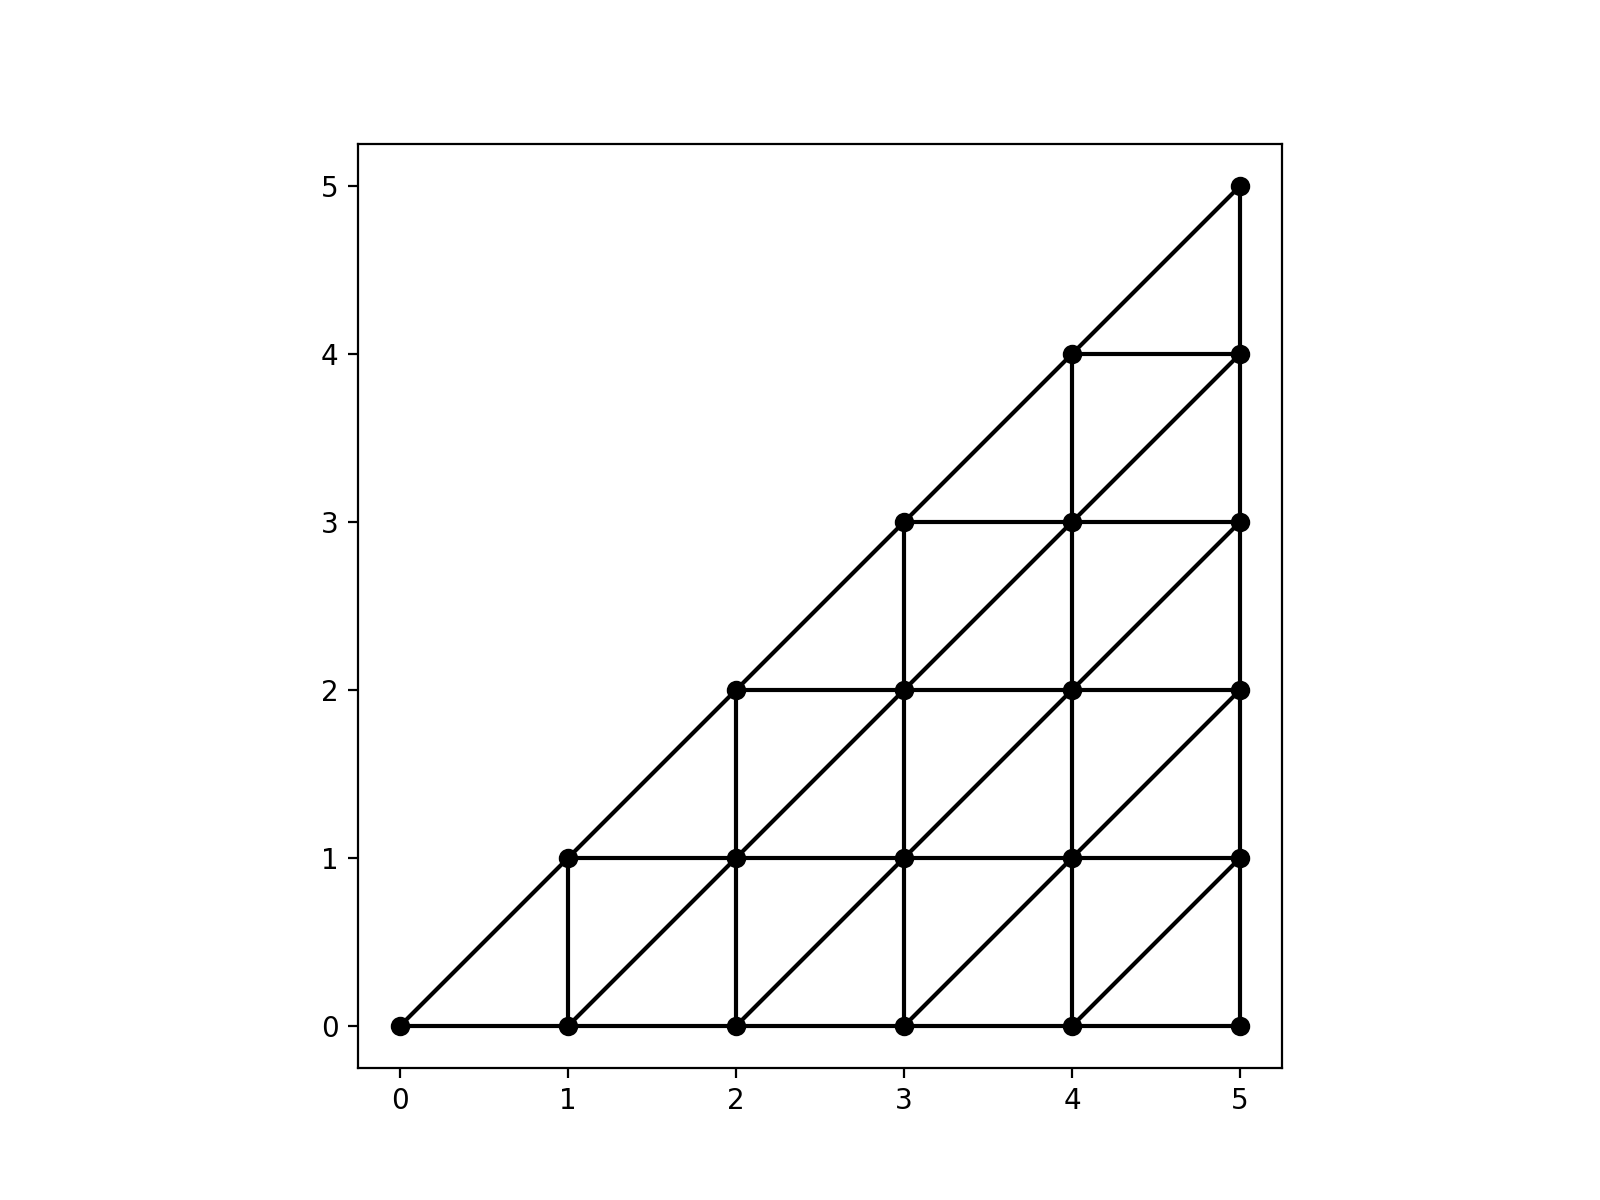

In [6]:
# Generate a sample mesh
Nsamp = 5
xsamp, zsamp = np.linspace(0, L, num=Nsamp+1), np.linspace(0, L, num=Nsamp+1)

xtrisamp = []
for i in range(Nsamp+1):
    xtrisamp.append(xsamp[i:])
xtrisamp = np.hstack(xtrisamp)
ztrisamp = np.repeat(zsamp, np.arange(1, Nsamp+2)[::-1])
npointssamp = xtrisamp.shape[0]

trirowssamp = []
for i in range(Nsamp+1, 1, -1):
    ti = i*(i+1)/2
    offset = npointssamp - ti
    for j in range(0, i-1):
        trirowssamp.append(np.array([offset + j, offset + j + 1, offset + j + i]))
    if i > 2:
        for j in range(1, i-1):
            trirowssamp.append(np.array([offset + j, offset + j + i, offset + j + i - 1]))
trisamp = np.vstack(trirowssamp)

fig, ax = plt.subplots()
ax.triplot(xtrisamp, ztrisamp, trisamp, 'k-o')
ax.set_aspect('equal')
plt.savefig('notebook-mesh.png', dpi=300)
plt.show()

# 3D: Two Receptors

<IPython.core.display.Javascript object>


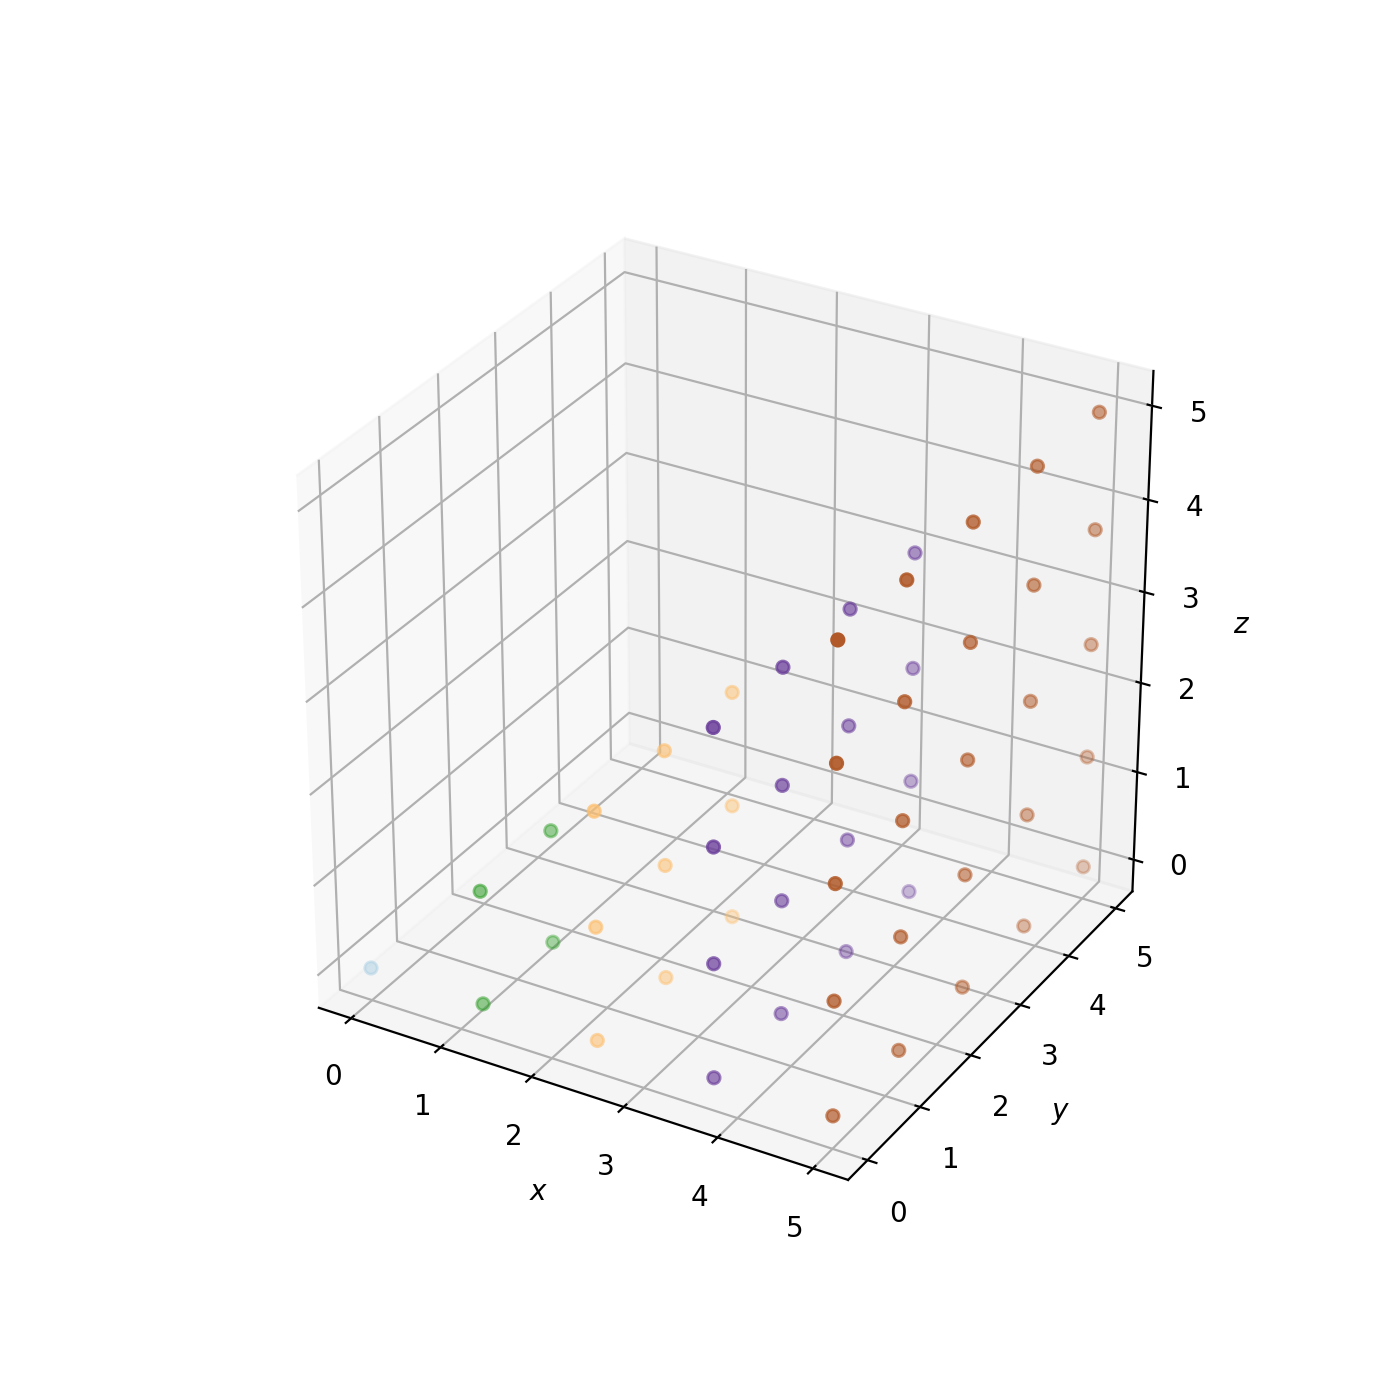

In [13]:
# Plot sample mesh
Nsamp = 4
L = 5
kf = 0
xsamp = np.linspace(0, L, num=Nsamp+1)

mesh = np.meshgrid(xsamp, xsamp, xsamp, indexing='ij')

vec = [el.flatten(order='F') for el in mesh]
mask = (vec[0] >= vec[1]) * (vec[0] >= vec[2])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vec[0][mask], vec[1][mask], vec[2][mask], c=vec[0][mask], cmap='Paired', depthshade=True)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
fig.savefig('3D-mesh.png', dpi=300)
plt.show()

In [8]:
N3 = 15
num_nodes3 = N3*(N3+1)*(2*N3+1)/6
ivec = np.arange(N3)
imesh = np.meshgrid(ivec, ivec, ivec, indexing='ij')
ivec = [el.flatten(order='F') for el in imesh]
imask = (ivec[0] >= ivec[1]) * (ivec[0] >= ivec[2])
nodeset = np.column_stack([el[imask] for el in ivec])
xvec3 = np.linspace(0, L, N3+1)[1:]
h = xvec3[1] - xvec3[0]

In [14]:
A3 = np.zeros(shape=(num_nodes3, num_nodes3))
rhs3 = np.zeros(shape=num_nodes3)
for (m, node) in enumerate(nodeset):
    i, j, k = node
    if i + 1 == N3:
        for (n, tnode) in enumerate(nodeset):
            ti, tj, tk = tnode
            if j == tj and k == tk:
                if ti + 1 == N3:
                    A3[m, n] = -1
                elif ti + 2 == N3:
                    A3[m, n] = 1
    elif j == 0:
        for (n, tnode) in enumerate(nodeset):
            ti, tj, tk = tnode
            if i == ti and k == tk:
                if tj == 0:
                    A3[m, n] = -1
                elif tj == 1:
                    A3[m, n] = 1
    elif k == 0:
        for (n, tnode) in enumerate(nodeset):
            ti, tj, tk = tnode
            if i == ti and j == tj:
                if tk == 0:
                    A3[m, n] = -1
                elif tk == 1:
                    A3[m, n] = 1
    else:
        rhs3[m] = -1
        y, z = xvec3[j], xvec3[k]
        for (n, tnode) in enumerate(nodeset):
            ti, tj, tk = tnode
            if np.linalg.norm([i - ti, j - tj, k - tk], ord=1) <= 1:
                if i == ti:
                    if j == tj:
                        if k == tk:
                            A3[m, n] = -2/h**2*(Dc + 2*Ds)
                        elif k + 1 == tk:
                            A3[m, n] = Ds/h**2 - kf/(2*h*gam)*(z-lam)
                        elif k - 1 == tk:
                            A3[m, n] = Ds/h**2 + kf/(2*h*gam)*(z-lam)
                    elif j + 1 == tj:
                        A3[m, n] = Ds/h**2 - kf/(2*h*gam)*(y-lam)
                    elif j - 1 == tj:
                        A3[m, n] = Ds/h**2 + kf/(2*h*gam)*(y-lam)
                elif np.abs(i - ti) == 1:
                    A3[m, n] = Dc/h**2

In [15]:
# print(Dc, Ds, kf, gam, lam, h3)
# test_index = 21
# print(A3[test_index])
# print(np.sum(A3[test_index]))
# print(nodeset[test_index])
# print(nodeset[A3[test_index].astype('bool')])

In [16]:
sol3 = np.linalg.solve(A3, rhs3)

<IPython.core.display.Javascript object>


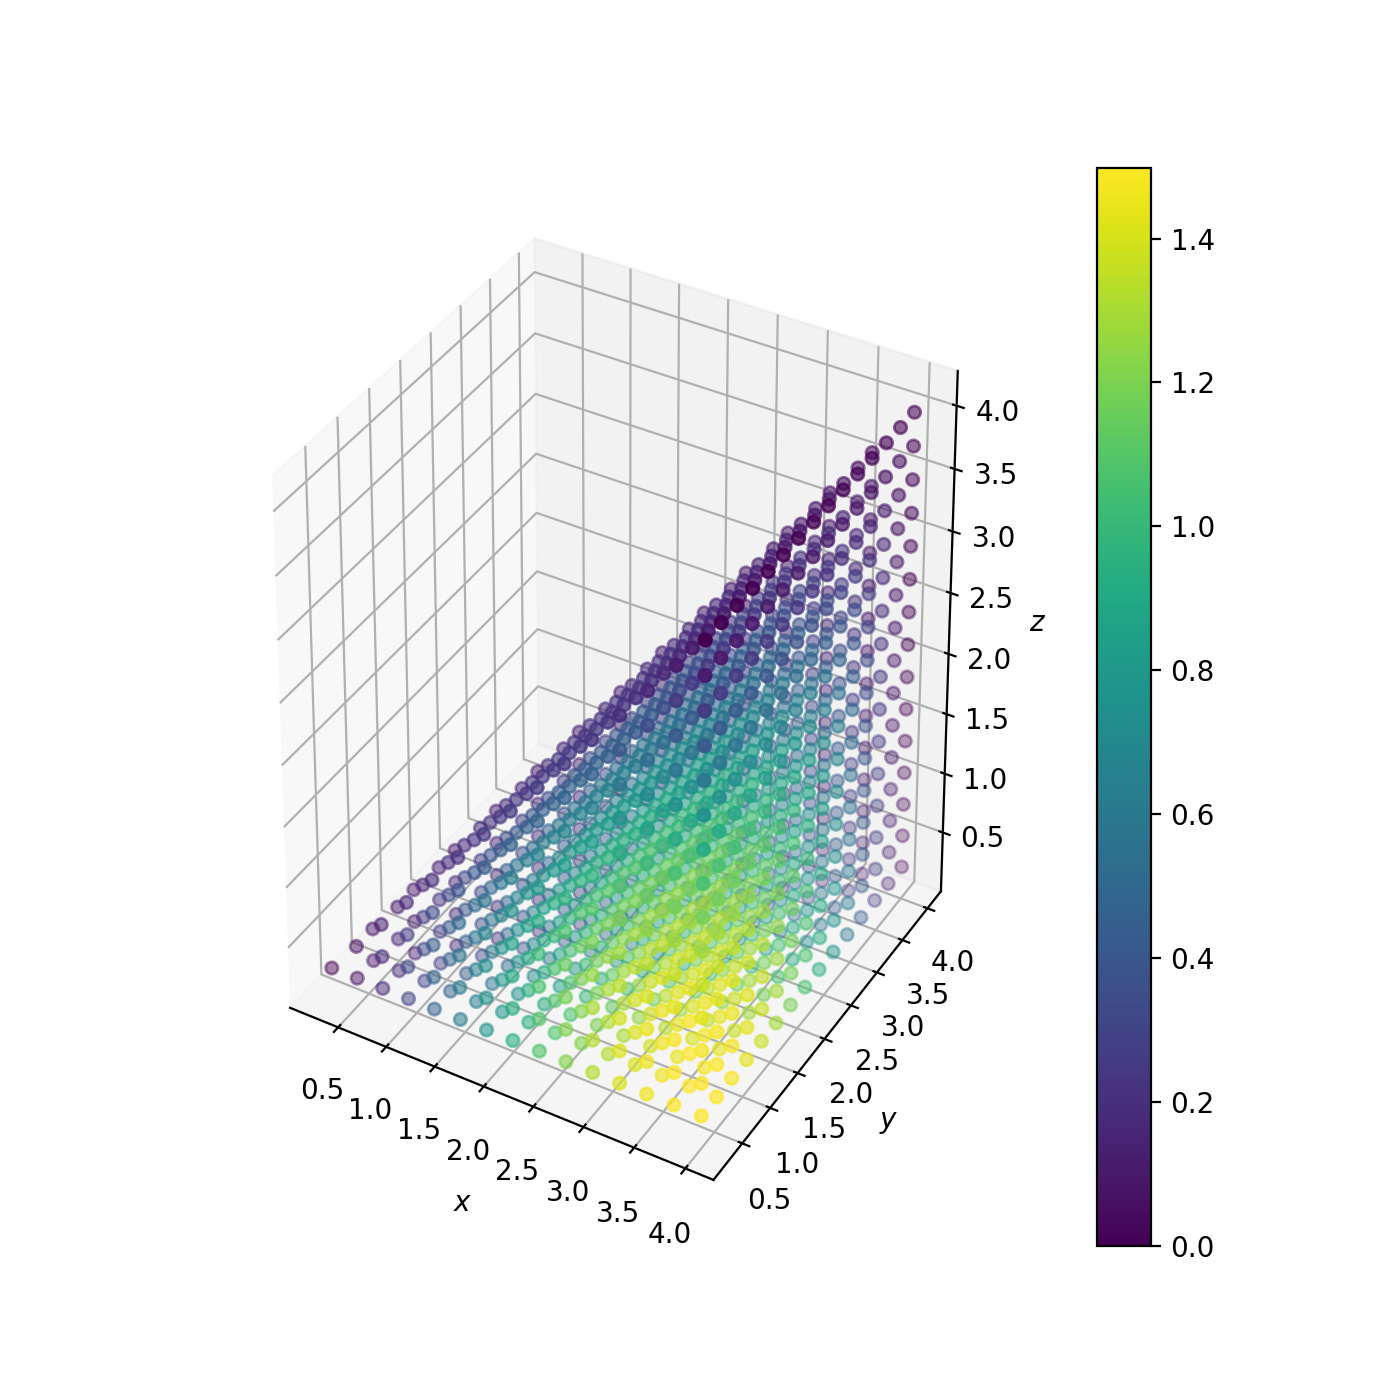

In [17]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
cb = ax.scatter(xvec3[nodeset[:, 0]], xvec3[nodeset[:, 1]], xvec3[nodeset[:, 2]],
           c=sol3, depthshade=True)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
fig.colorbar(cb)
plt.show()